In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse.linalg import LinearOperator, cg, lsqr

import torch
import torch.nn as nn
import pylops
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.optimization.sparsity  import *
from torch.optim.lr_scheduler import StepLR

In [2]:
# EXPERIMENT PARAMS
from pyfrac.hydrafrac.acquisition import recgeom,rec2das_datatrnsfrm,dasgeom

# LOCATION
from pyfrac.pseudodas.receiveroperators import cubePDoperator
from pyfrac.imaging.kirchhoff import Kirchhoff
from pyfrac.imaging.crosscorr_imaging import XcorrObjFunc
from pyfrac.utils.localisationutils import get_max_locs

# VISUALISATION
from pyfrac.visualisation.traceviz import traceimage, wiggleplot
from pyfrac.visualisation.eventimages import locimage3d

# LOAD DATA

In [3]:
expname = 'LRBDASgeom'
projpath = '/home/birniece/Documents/Projects/MicroseismicModelling/MicroseismicProcessing/FDModelling/HomoLRB_DAS'
seispath = os.path.join(projpath,'outputs/su/')

In [4]:
gridded_recs = np.loadtxt(os.path.join(projpath,'inputs/receiver.dat'))
nr = len(gridded_recs)


In [5]:
vz_file = os.path.join(seispath,'%s_div.txt'%expname)
vz_flat = np.loadtxt(vz_file,delimiter="\n")
nt = int(vz_flat.shape[0]/nr)

print('nt:%i, nr:%i'%(nt,nr))

nt:10000, nr:8664


(8664, 100)


Text(0.5, 1.0, 'FD Modelled Data (orig.)')

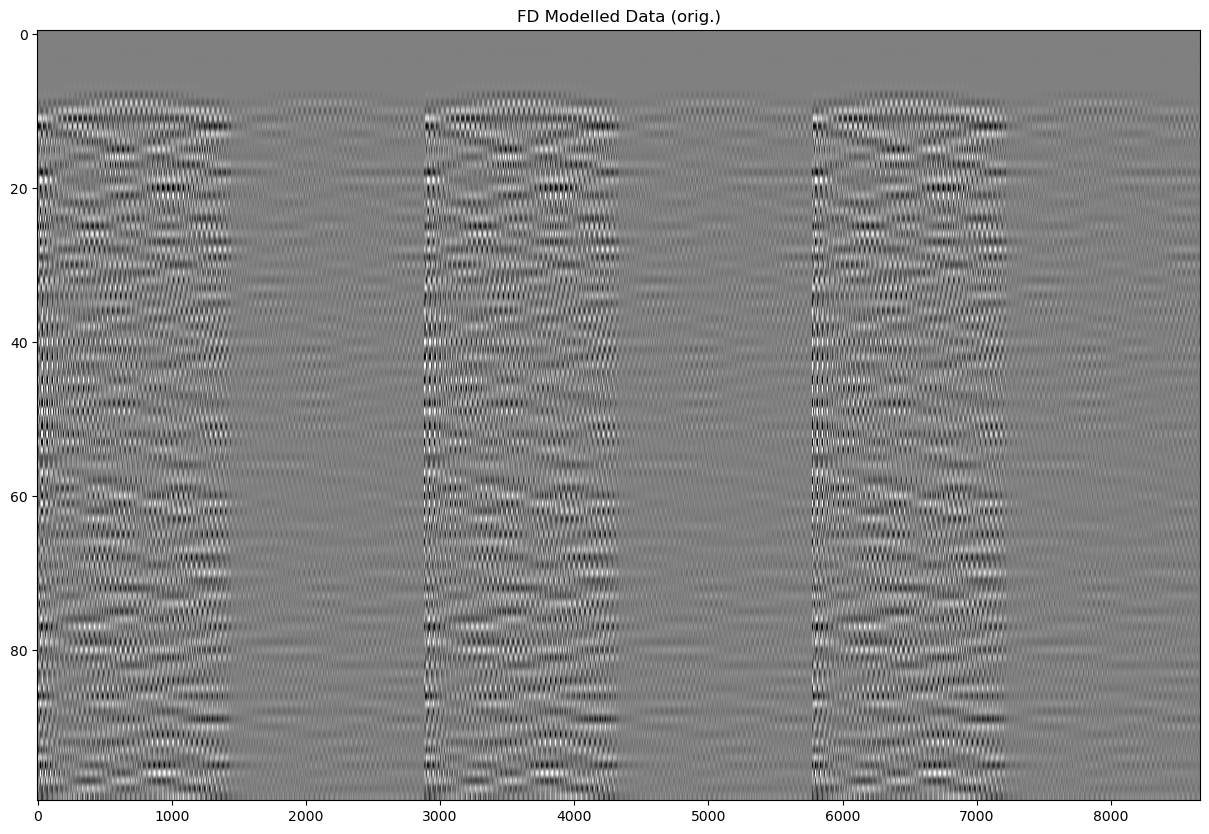

In [6]:
try: 
    vz_flat.reshape((nr,nt))
except:
    print('Not good dims \n nt:%i nr:%i \n vz flat:%i'%(nt,nr,vz_flat.shape[0]))
    
vz = vz_flat[:nt*nr].reshape((nr,nt))[:,::100]
print(vz.shape)
seislim = np.percentile(abs(vz),99.)
vmin=-1*seislim
vmax=seislim    
cmap='binary'
              
plt.figure(figsize=[15,10])
plt.imshow(vz.T, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax, interpolation=None)
plt.title('FD Modelled Data (orig.)')

# Subsample

In [7]:
num_per_line = 4
line_locs = np.around(np.linspace(0.02,0.38, num_per_line),2)
line_locs

array([0.02, 0.14, 0.26, 0.38])

In [8]:
keep_rec_indices = []
for i,rec in enumerate(gridded_recs):
    # X Faces
    if rec[0] == 0.01 or  rec[0] == 0.4:
        if rec[1] in line_locs and  rec[2] in line_locs :
            keep_rec_indices.append(i)
    # Y Faces
    if rec[1] == 0.01 or  rec[1] == 0.4:
        if rec[0] in line_locs and  rec[2] in line_locs :
            keep_rec_indices.append(i)
    # Z Faces
    if rec[2] == 0.01 or  rec[2] == 0.4:
        if rec[1] in line_locs and  rec[0] in line_locs :
            keep_rec_indices.append(i)

In [9]:
len(keep_rec_indices)

96

Text(0.5, 1.0, 'FD Modelled Data (subsamp)')

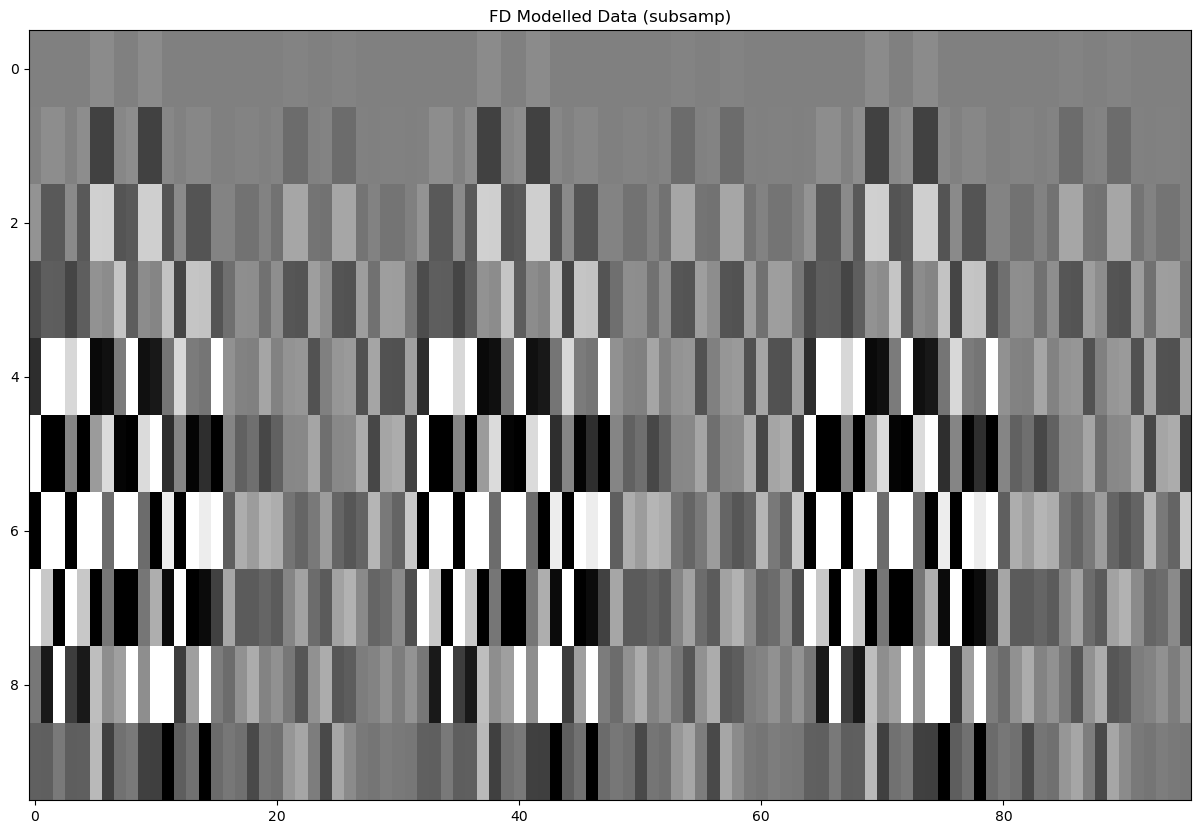

In [10]:
recs = gridded_recs[keep_rec_indices]
nr_sbsmp = len(recs)
data_sbsmp = vz[keep_rec_indices]
moddata = data_sbsmp[:,7:97] # Shifting so arrival is at correct time

plt.figure(figsize=[15,10])
plt.imshow(moddata[:,:10].T, aspect='auto', cmap='binary', vmin=vmin*0.5, vmax=vmax*0.5, interpolation=None)
plt.title('FD Modelled Data (subsamp)')

# Make operator

In [11]:
# Velocity Model
nx, ny, nz = 40, 40, 40
dx, dy, dz = 0.01, 0.01, 0.01
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

v0 = 5260 # initial velocity
kv = 0. # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

In [12]:
fwav = 25*1000
fs_kHz = 100
fs = fs_kHz * 1000

dt = 1/fs
ntfrwd = vz.shape[1]-10
t = (np.arange(nt)*dt)[:ntfrwd]
wav, wavt, wavc = ricker(t[:41], f0=fwav)

In [13]:
# INITIALISE OPERATOR
Op = Kirchhoff(z=z, 
               x=x, 
               y=y, 
               t=t, 
               srcs=recs.T[:, :1], 
               recs=recs.T, 
               vel=v0, 
               wav=wav, 
               wavcenter=wavc, 
               mode='analytic', 
               engine='numba')

(96, 90)


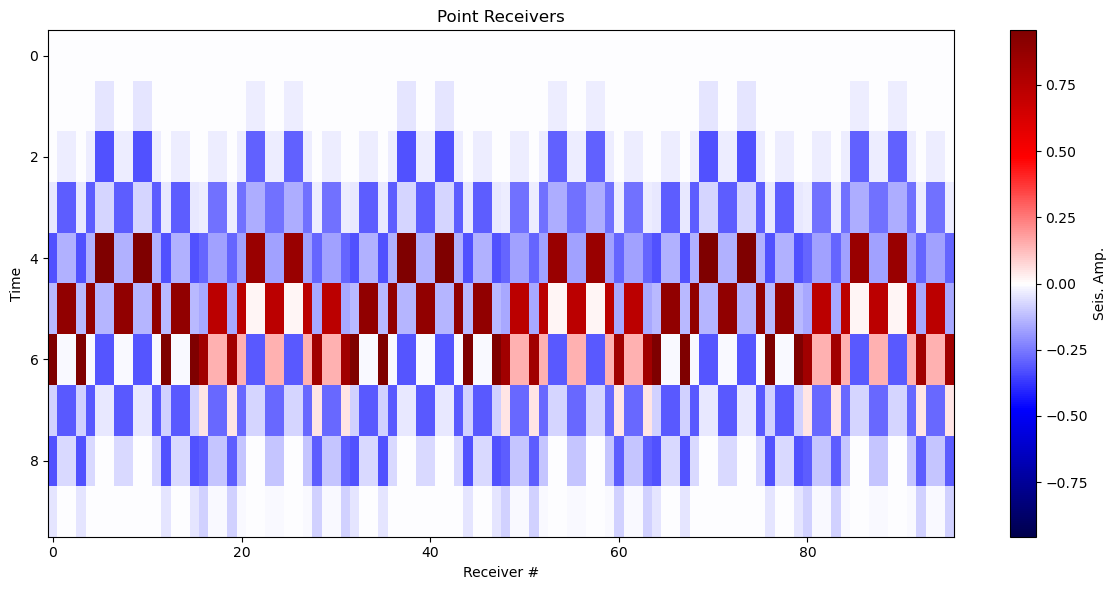

In [14]:
# PERFORM FORWARD (MODEL)
sx, sy, sz = [nx//2, ny//2, nz//2]
microseismic = np.zeros((nx, ny, nz))
microseismic[sx, sy, sz] = 1.

frwddata_1d = Op @ microseismic.flatten().squeeze()
frwddata  = frwddata_1d.reshape(nr_sbsmp,ntfrwd)
fig,ax = traceimage(frwddata[:,:10], climQ=99.99)
ax.set_title('Point Receivers')

print(frwddata.shape)

# IMAGE

Migration-Based Hypo Center: [19.5 19.7 19.9]


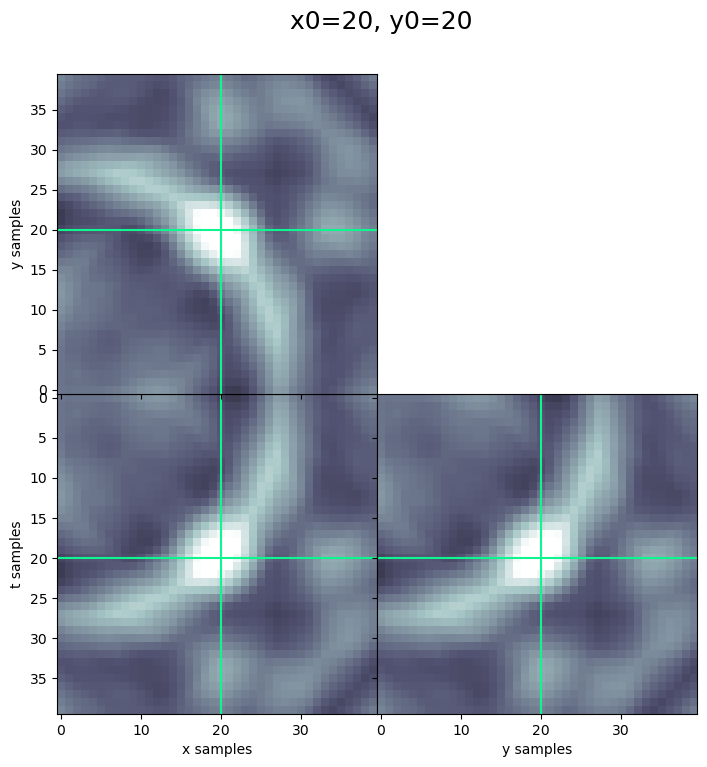

In [15]:
migrated = (Op.H @ moddata).reshape(nx,ny,nz)
hc, hcs =  get_max_locs(migrated, n_max=10, rem_edge=False)
print('Migration-Based Hypo Center:',hc.flatten())
fig,axs = locimage3d(migrated,20,20)


 
LSQR            Least-squares solution of  Ax = b
The matrix A has 8640 rows and 64000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   5.047e+04  5.047e+04    1.0e+00  3.1e-04
     1  1.35677e-01   5.030e+04  5.030e+04    1.0e+00  8.2e-02   1.9e+02  1.0e+00
     2  4.07200e-01   5.014e+04  5.014e+04    9.9e-01  4.2e-02   3.3e+02  3.0e+00
     3  7.50982e-01   5.002e+04  5.002e+04    9.9e-01  3.2e-02   4.2e+02  5.1e+00
     4  1.01933e+00   4.992e+04  4.992e+04    9.9e-01  2.3e-02   5.1e+02  7.6e+00
     5  1.27178e+00   4.983e+04  4.983e+04    9.9e-01  1.8e-02   5.8e+02  1.0e+01
     6  1.40718e+00   4.977e+04  4.977e+04    9.9e-01  1.2e-02   6.4e+02  1.3e+01
     7  1.51182e+00   4.973e+04  4.973e+04    9.9e-01  9.5e-03   6.9e+02  1.5e+01
     8  1.69671e+00   4.971e+04  

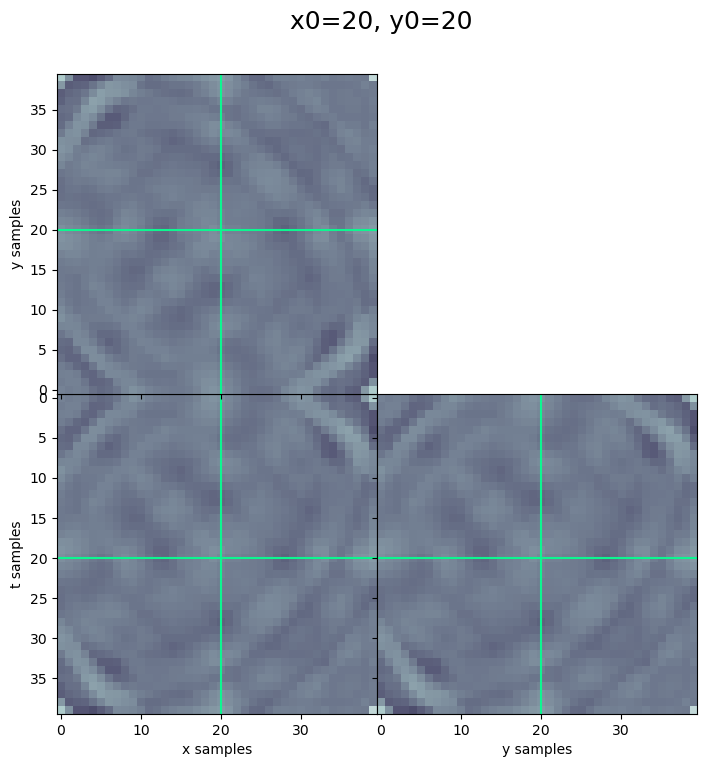

In [16]:
inv = (lsqr(Op, moddata.ravel(), iter_lim=100, show=True)[0]).reshape(nx,ny,nz)
hc, hcs =  get_max_locs(inv, n_max=10, rem_edge=False)
print('LSQR Computed Hypo Center:',hc.flatten())
fig,axs = locimage3d(inv,sx,sy)

In [17]:
migrated.copy().ravel() 

array([ 4894.66956486,  3177.75252445,  2145.73738779, ...,
       -1156.80639842, -1274.38166643, -1278.42563473])

In [18]:
np.shape(np.random.random(migrated.shape)-0.5)

(40, 40, 40)

0.00012763158576298056
Iteration 0, Loss: -0.06359
Iteration 10, Loss: -0.06431
Iteration 20, Loss: -0.06503
Iteration 30, Loss: -0.06540
Iteration 40, Loss: -0.06577
Iteration 50, Loss: -0.06595
Iteration 60, Loss: -0.06614
Iteration 70, Loss: -0.06623
Iteration 80, Loss: -0.06632
Iteration 90, Loss: -0.06637
Iteration 100, Loss: -0.06642
Iteration 110, Loss: -0.06644
Iteration 120, Loss: -0.06647
Iteration 130, Loss: -0.06648
Iteration 140, Loss: -0.06649
Iteration 150, Loss: -0.06649
Iteration 160, Loss: -0.06650
Iteration 170, Loss: -0.06650
Iteration 180, Loss: -0.06651
Iteration 190, Loss: -0.06651
Iteration 200, Loss: -0.06651
Iteration 210, Loss: -0.06651
Iteration 220, Loss: -0.06651
Iteration 230, Loss: -0.06651
Iteration 240, Loss: -0.06651
Iteration 250, Loss: -0.06651
Iteration 260, Loss: -0.06651
Iteration 270, Loss: -0.06651
Iteration 280, Loss: -0.06651
Iteration 290, Loss: -0.06651
Iteration 300, Loss: -0.06651
Iteration 310, Loss: -0.06651
Iteration 320, Loss: -0.0665

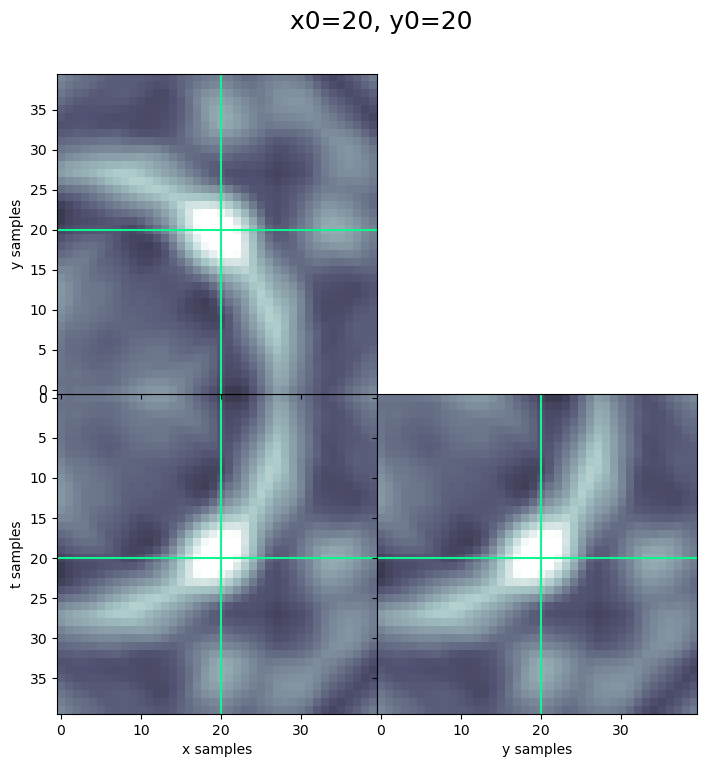

In [23]:
dmigrated = Op @ migrated.ravel()
scaling = moddata.max() / dmigrated.max() 
print(scaling)

# Initialising with migrated image
init_damp = 1e-3
init_noise = (np.random.random(migrated.shape)-0.5) * init_damp
m = torch.from_numpy((migrated.copy().ravel()* scaling) + init_noise.copy().ravel()) 
m.requires_grad = True # make sure we compute the gradient with respect to x

dobs = torch.from_numpy(moddata.copy().ravel())
# print(dobs.min().item(), dobs.max().item())
TOp = pylops.TorchOperator(Op)

# Optimization
optimizer = torch.optim.SGD([m], lr=1e2)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
niter = 500
eps = 1e-6

losshist = np.zeros(niter)
for i in range(niter):
    optimizer.zero_grad()
    d = TOp(m)
    # print(d.min().item(), d.max().item(), dobs.min().item(), dobs.max().item())
    
    # data term
    lossd = XcorrObjFunc(d, dobs)  
#     print(lossd)
    # L1 reg
    reg = torch.sum(torch.abs(m))  
#     print(reg)  
#     print(eps * reg)
    # total loss
    loss = lossd + eps * reg
    
    loss.backward()
    optimizer.step()
    scheduler.step()
    losshist[i] = loss.item()
    if i % 10 == 0:
        print(f'Iteration {i}, Loss: {loss.item():.5f}')

dls_torch = d.detach().cpu().numpy().reshape(moddata.shape)
mls_torch = m.detach().cpu().numpy().reshape(nx, ny, nx)

hc, hcs =  get_max_locs(mls_torch, n_max=10, rem_edge=False)
print('XCorr. Computed Hypo Center:',hc.flatten())
fig,axs = locimage3d(mls_torch,sx,sy)